In [1]:
import pandas as pd

def MakeLabelsFromTimeLine(data,columns=["raceid","label","start","end"],fps = 25):
    data2ext = [columns]
    for i,x in data.iterrows():
        raceid = x["raceid"]
        tp  =max(x["TURNING"],x["LAST"]) 
        newEvent = [raceid,f"PRE",x["FIRST"]-fps*15,x["FIRST"]+fps*2]
        # data2ext.append(newEvent) 
        # newEvent = [raceid,"NOT",min(2000,x["FIRST"]-fps*180),x["FIRST"]-fps*60]
        data2ext.append(newEvent) 
        newEvent = [raceid,f"{ESDname}_ENT",x["FIRST"]-fps*5,x["FIRST"]+fps*5]
        data2ext.append(newEvent)
        newEvent = [raceid,f"{ESDname}_ONT",x["FIRST"]+fps*2,tp+fps*1]
        data2ext.append(newEvent)
        newEvent = [raceid,f"{ESDname}_TRG",tp-fps*1,tp+fps*5]
        data2ext.append(newEvent)
        newEvent = [raceid,"POST",tp+fps*10,max(x["TURNING"],x["LAST"])+fps*10]
        data2ext.append(newEvent)
            
    return data2ext

#get all ESD data overlap with raceid and start end
def checkOverlap(raceid,start,end,ESD):
    def frameoverlap(a,b):
        return max(0, min(a[1], b[1]) - max(a[0], b[0]))
    label = None
    for esd in ESD.iterrows():
        idx = esd[0]
        itm = esd[1]
        esdstart = itm["startframe"]
        esdend = itm["endframe"]
        if frameoverlap([start,end],[esdstart,esdend]) > 0:
            # print(f"Overlap with {itm['label']} {esdstart} - {esdend}")
            label = itm['label']
    return label


def createTimeline(raceid,pdf):
    racepoints = pdf[pdf["raceid"]==raceid].sort_values("startframe")
    timelinedata = racepoints[["label","startframe"]]

    # Initialize variables
    batches = []
    current_batch = {'FIRST': None, 'TURNING': None, 'LAST': None}

    # Iterate over the DataFrame
    for index, row in timelinedata.iterrows():
        label, frame = row['label'], row['startframe']
        current_batch[label] = frame

        # If the batch is complete, add it to batches
        if all(current_batch.values()):
            batches.append([current_batch['FIRST'], current_batch['TURNING'], current_batch['LAST']])
            current_batch = {'FIRST': None, 'TURNING': None, 'LAST': None}  # Reset for the next batch

    # Add any incomplete batch if needed
    if any(current_batch.values()):
        batches.append([current_batch['FIRST'], current_batch['TURNING'], current_batch['LAST']])

    # Create a DataFrame from the batches
    batch_data = []
    for batch in batches:
        # flat_batch = ['FIRST', batch[0], 'TURNING', batch[1], 'LAST', batch[2]]
        flat_batch = [raceid , batch[0], batch[1],batch[2],]
        batch_data.append(flat_batch)

    # Handle missing values (replace None with 'NaN' or leave as is)
    batch_data = [[value if value is not None else 'NaN' for value in batch] for batch in batch_data]

    # Create a new DataFrame
    columns = [ "raceid", 'FIRST', 'TURNING', 'LAST',]
    new_df = pd.DataFrame(batch_data, columns=columns)
    # Add Order column (descending order)
    new_df['Order'] = range(len(new_df), 0, -1)
    # print(new_df)
    return new_df

In [2]:
df = pd.read_csv("/home/amir/project/bitbucket/sequence_analyzer/DATA_TOOLS/FRV_ESD_POINTS.csv")
timeline = []
pdf = df[df["type"]=='POINT']
for raceid in pdf["raceid"].unique():
    tt = createTimeline(raceid,pdf)
    for t in tt.values:
        timeline.append(t)

columns = [ "raceid", 'FIRST', 'TURNING', 'LAST', 'order']
allstarts = pd.DataFrame(timeline, columns=columns)
allstarts.to_csv("ALLTIMELINE.csv",index=False)

/tmp/ipykernel_2850760/1801039341.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/amir/project/bitbucket/sequence_analyzer/DATA_TOOLS/FRV_ESD_POINTS.csv")


In [3]:
allstarts

,raceid,FIRST,TURNING,LAST,order
0,2021041700105,16045,16210,16220,1
1,2022040107001,7465,7640,7710,2
2,2022040107001,8265,8445,8505,1
3,2023021607001,5475,5625,5650,2
4,2023021607001,8910,9010,9065,1
...,...,...,...,...,...
10717,2024043000102,7125,7190,7215,1
10718,2022122300105,7825,7920,7990,1
10719,2024092000101,6945,7010,7090,1
10720,2021122400108,13370,13435,13495,1


In [4]:
# allstarts[allstarts["raceid"] == 2021060401001]
badraces = []
for stt in allstarts.iterrows():
    idx = stt[0]
    itm = stt[1]
    raceid = itm["raceid"]
    
   

    try:
        FIRST = int(itm["FIRST"])
        LAST = int(itm["LAST"])
        TRUN = int(itm["TURNING"])
        #chec if Firs > Turning > Last
        if  FIRST > max(TRUN,LAST):
            # print(f"Error in {raceid} {FIRST} {TRUN} {LAST}")
            badraces.append(raceid)
    except:
        pass
        # print(raceid,itm)
        # print(f"Error in {raceid} {FIRST} {TRUN} {LAST}")
        badraces.append(raceid)
        # continue

badraces = list(set(badraces))
len(badraces)
badraces
for rid in badraces:
    link = f"13.228.134.229/system/labeltask/{rid}_15680_16660"
    print(rid)

    ddd = allstarts[allstarts["raceid"] == rid]
    print(ddd)

2022031104008
             raceid  FIRST TURNING   LAST  order
1992  2022031104008   9995   10170  10165      5
1993  2022031104008  10915   10895  10975      4
1994  2022031104008  12410   12590  12595      3
1995  2022031104008  14785   14950  12945      2
1996  2022031104008    NaN     NaN  14995      1
2023060508701
             raceid FIRST TURNING  LAST  order
5290  2023060508701  6920    6325  7125      2
5291  2023060508701   NaN    7140   NaN      1
2024103000106
              raceid  FIRST TURNING LAST  order
10577  2024103000106  16500     NaN  NaN      1
2021062803503
             raceid  FIRST TURNING   LAST  order
7551  2021062803503  10490   10530  10540      2
7552  2021062803503  10560     NaN  10600      1
2021062803504
             raceid FIRST TURNING  LAST  order
7494  2021062803504  7120    7095  7150      2
7495  2021062803504  7170     NaN  7220      1
2022061203504
             raceid  FIRST TURNING  LAST  order
8789  2022061203504   7605    7635  7760      4
8

In [6]:
actualstart = allstarts[allstarts["order"] == 1]
print(len(actualstart["raceid"].unique()))
actualstart

earliestStarts = allstarts.loc[allstarts.groupby("raceid")["order"].idxmax()]
earliestStarts

7453


,raceid,FIRST,TURNING,LAST,order
4533,2021040302701,19325,19450,19505,1
8478,2021040302702,13585,13745,13835,1
8435,2021040302703,13705,13880,13970,1
8419,2021040302704,18000,18200,18190,1
8394,2021040302706,16480,16625,16645,3
...,...,...,...,...,...
10100,2024111700106,6205,6310,6395,1
9954,2024111700109,7440,7440,7595,1
10660,2024111800101,6880,6950,7015,1
10093,2024111800105,8825,9045,9090,2


# ESD OVERLAP FIND

In [3]:
df = pd.read_csv("ALLDATA.csv",low_memory=False)
# Replace 'BL' and 'BR' with 'back'
df.loc[df['label'].isin(['BL', 'BR','BACK']), 'label'] = 'BACK'
df.loc[df['label'].isin(['FR', 'FL',"FLV", "FRV"]), 'label'] = 'FRONT'
df.loc[df['label'].isin(['FLD', 'LEFTVD', 'LEFTD',"FRD"]), 'label'] = 'DRONE'
df.loc[df['label'].isin(['LEFT',"LEFTV"]), 'label'] = 'LEFT'
df.loc[df['label'].isin(['RIGHT']), 'label'] = 'RIGHT'
df.loc[df['label'].isin(['CANCEL',"CANCELV"]), 'label'] = 'CANCEL'
# List of labels to drop
labels_to_drop = ['ERROR-VIDEO', 'FRV2', 'RIGHTS',
       'ERROR-VIDEOV','UNRELATEDV','UNRELATED','OD']
# Drop rows where 'label' is in the list
df = df[~df['label'].isin(labels_to_drop)]

ESD = df[df["type"] == "ESD"]
ESD

,Unnamed: 0,id,created_at,updated_at,label,type,hard,raceid,trk,startframe,...,AI_VERIFY,AI_COMMENT,AI_THINKS,AI_CORRECT,trackmaster,chrono,chrono_type,chrono_userid,replay,chrono_verify
0,0,40,2024-04-03T18:02:02.000000Z,2024-06-23T02:30:46.000000Z,FRONT,ESD,NaN,2021041700105,1,16020,...,1.0,"[[1,""T001FR"",0.994]]",1.0,0.0,0,NaN,NaN,NaN,NaN,0
4,4,44,2024-04-14T23:58:07.000000Z,2024-06-20T01:59:23.000000Z,FRONT,ESD,NaN,2021041505907,59,11300,...,1.0,"[[112,""T059FR"",0.986]]",1.0,98.0,0,NaN,NaN,NaN,NaN,0
5,5,48,2024-04-15T16:45:03.000000Z,2024-06-20T00:43:42.000000Z,FRONT,ESD,NaN,2023010100106,1,8425,...,1.0,"[[1,""T001FR"",0.963]]",1.0,0.0,0,NaN,NaN,NaN,NaN,0
6,6,49,2024-04-15T18:44:42.000000Z,2024-06-20T00:43:43.000000Z,LEFT,ESD,NaN,2023091700108,1,6845,...,1.0,"[[1,""T001FR"",0.987]]",1.0,0.0,0,NaN,NaN,NaN,NaN,0
8,8,57,2024-04-30T18:23:20.000000Z,2024-06-19T00:39:12.000000Z,FRONT,ESD,NaN,2024021307001,70,6000,...,1.0,"[[123,""T070FL"",0.985]]",1.0,98.0,1,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69870,69870,79942,2025-01-27T06:00:04.000000Z,2025-01-27T06:00:04.000000Z,FRONT,ESD,0.0,2024071014901,149,2985,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
69873,69873,79945,2025-01-27T06:00:24.000000Z,2025-01-27T06:00:24.000000Z,CANCEL,ESD,0.0,2024071014901,149,2260,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
69877,69877,79949,2025-01-27T07:03:46.000000Z,2025-01-27T07:03:46.000000Z,BACK,ESD,0.0,2021040600106,1,10710,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
69878,69878,79950,2025-01-27T07:04:19.000000Z,2025-01-27T07:04:19.000000Z,FRONT,ESD,0.0,2021040600106,1,10870,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0


In [7]:
data2ext = []
# Get aLL ACTUAL STARTS ONLY (LAST START in video end)
for sss in allstarts.iterrows():

    
    # ESDdata = ESD[ESD["raceid"]==rid]
    # if len(ESDdata) < 1:
    #     continue
    # print(ESDdata[["startframe","endframe"]])
    idx = sss[0]
    itm = sss[1] # dictionary
    
    itm['FIRST'] = pd.to_numeric(itm['FIRST'], errors='coerce')
    itm['TURNING'] = pd.to_numeric(itm['TURNING'], errors='coerce')
    itm['LAST'] = pd.to_numeric(itm['LAST'], errors='coerce')
    itm['order'] = pd.to_numeric(itm['order'], errors='coerce')
    rid = itm['raceid']
    FIRST = itm['FIRST']
    #if tunrning or last is nan then usewhichever is not nan is endtime but if both are not nan then use the max, else both nan then continue
    if pd.isna(itm['TURNING']) and pd.isna(itm['LAST']):
        # print("BOTH NAN")
        continue
    elif pd.isna(itm['TURNING']):
        # print("TURNING IS NAN")
        ENDTIME = int(float(itm['LAST']))
    elif pd.isna(itm['LAST']):
        # print("LAST IS NAN")
        ENDTIME = int(float(itm['TURNING']))
    else:
        # print("BOTH NOT NAN_____________")
        # print(itm['TURNING'], itm['LAST'])
        # Filter out NaN values and find the max
        ENDTIME = int(max(int(float(itm['TURNING'])), int(float(itm['LAST']))))

    fps = 25
    if itm["order"] == 1:    
        newEvent = [rid,f"ENT",FIRST-fps*2,FIRST+fps*5]
        data2ext.append(newEvent)
        newEvent = [rid,f"ONT",FIRST+fps*2,ENDTIME+fps*1]
        data2ext.append(newEvent)
        newEvent = [rid,f"TRG",ENDTIME-fps*1,ENDTIME+fps*5]
        data2ext.append(newEvent)
    else:
        newEvent = [rid,f"ENT",FIRST-fps*2,FIRST+fps*5]
        data2ext.append(newEvent)
    #     newEvent = [rid,f"BAD_ONT",FIRST+fps*2,ENDTIME+fps*1]
    #     data2ext.append(newEvent)
    #     newEvent = [rid,f"BAD_TRG",ENDTIME-fps*1,ENDTIME+fps*5]
    #     data2ext.append(newEvent)


    if itm["order"] == 1:
        newEvent = [rid,"POST",ENDTIME+fps*5,ENDTIME+fps*10]
        data2ext.append(newEvent)       
    
    racestatrt = allstarts[allstarts["raceid"] == rid]
    if itm["order"] == racestatrt["order"].max():
        FIRST = itm['FIRST']
        newEvent = [rid,f"PRE",FIRST-fps*20,FIRST-fps*10]
        data2ext.append(newEvent) 
        newEvent = [rid,f"NOT",FIRST-fps*60,FIRST-fps*30]
        data2ext.append(newEvent)  
    
#compare 2 range of frames if they overlap as a def 



In [9]:
#make df data2ext
columns = ["raceid","label","start","end"]
timedf = pd.DataFrame(data2ext,columns=columns)
timedf = timedf.dropna()
timedf["start"] = timedf["start"].astype(int)
timedf["end"] = timedf["end"].astype(int)

timedf.to_csv("ALL_LAST_STARTS.csv",index=False)

In [62]:

for timedata in timedf.iterrows():
    idx = timedata[0]
    itm = timedata[1]
    raceid = itm["raceid"]
    start = itm["start"]
    end = itm["end"]
    labelSEQ = itm["label"]
    raceESD = ESD[ESD["raceid"]==raceid]
    # print(f"Checking {raceid} {labelSEQ} {start} - {end}")
    # print(raceESD[["label","startframe","endframe"]])
    labelESD = checkOverlap(raceid,start,end,raceESD)
    
    # print(f"ESD {labelESD}")
    #update columns with ESD label
    timedf.at[idx,"ESD"] = labelESD
    

2021121802202  ######################### 6


<Figure size 640x480 with 0 Axes>

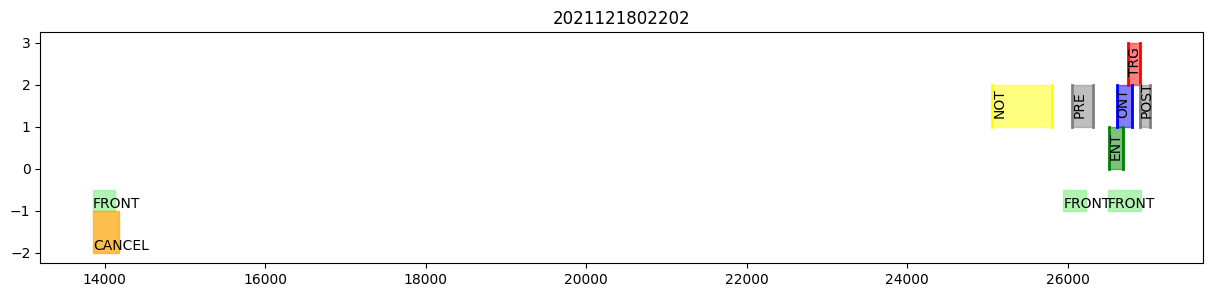

<Figure size 640x480 with 0 Axes>

In [89]:
import random
def plotOverlapsESD(racetimedf,raceESD,show=False):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from matplotlib.ticker import MaxNLocator
    import numpy as np
    plt.clf()
    fig, ax = plt.subplots()
    #set fig size 
    fig.set_size_inches(15, 3)
    # Plot the data
    
    label_to_level = {
    "ENT": 0,
    "ONT": 1,
    "TRG": 2,

    "BAD_ENT": 0,
    "BAD_ONT": 1,
    "BAD_TRG": 2,

    "NOT": 1,
    "PRE": 1,
    "POST": 1  # Shared level for similar labels
    }

    for idx, row in racetimedf.iterrows():
        raceid = row["raceid"]
        label = row["label"]
        start = row["start"]
        end = row["end"]
        esd = row["ESD"]
        
        # Determine the color based on the label
        if "ENT" in label:
            color = "green"
        elif "ONT" in label:
            color = "blue"
        elif "TRG" in label:
            color = "red"
        elif "NOT" in label:
            color = "yellow"
            # continue
        elif "PRE" in label:
            color = "gray"
            
        elif "POST" in label:
            color = "gray"
        elif "CANCEL" in label:
            color = "orange"
      
        # Assign the y-level based on the label
        y_level = label_to_level.get(label, 0)  # Default to level 0 if not found
        # Plot the start line
        ax.plot([start, start], [y_level, y_level + 1], color=color, linewidth=2)
        # print([start, start], [y_level, y_level + 1])
        # Plot the end line
        ax.plot([end, end], [y_level, y_level + 1], color=color, linewidth=2)
        # print([end, end], [y_level, y_level + 1])
        # Plot the rectangle
        ax.add_patch(patches.Rectangle((start, y_level), end - start, 1, color=color, alpha=0.5))
        # Add the label
        # print(f"{raceid} {label} {start} - {end} {esd} , color {color} y_level {y_level}")
        ax.text(start, y_level + 0.2, label, rotation=90, verticalalignment='bottom')
        # ax.text(start, y_level + 0.5, esd, rotation=90, verticalalignment='bottom')
        


    #plot esd areas 
    for esd in raceESD.iterrows():
        idx = esd[0]
        itm = esd[1]
        esdstart = itm["startframe"]
        esdend = itm["endframe"]
        label = itm["label"]
        
        if "CANCEL" in label:
            color = "orange"
            xpos = -1
        else:
            xpos = -0.5
            color = "lightgreen"

             
        ax.add_patch(patches.Rectangle((esdstart, xpos), esdend-esdstart, xpos, color=color, alpha=0.7))
        ax.text(esdstart, xpos-abs(xpos), itm["label"], rotation=0, verticalalignment='bottom')
        
    #make dir
    import os
    if not os.path.exists("TIMELINE"):
        os.makedirs("TIMELINE")
    #save fig
    
    ax.title.set_text(raceid)
    if show:
        plt.show()
    plt.savefig(f"TIMELINE/{raceid}.png")
   
count = 0

cancelraces = ESD[ESD["label"] == "CANCEL"]["raceid"].unique()
random.shuffle(cancelraces)


allraceids = timedf["raceid"].unique()
#cancelraces by random 

for raceid in cancelraces:
    # if not raceid == 2023122600106:
    #     continue
    RACETIMEDF = timedf[timedf["raceid"]==raceid]
    print(raceid," #########################",len(RACETIMEDF))
    if len(RACETIMEDF) < 1:
        continue
    raceESD = ESD[ESD["raceid"]==raceid]
    # print(RACETIMEDF)
    # print(raceESD[['label','startframe','endframe']])
    plotOverlapsESD(RACETIMEDF,raceESD,show=True)
    break
    

  

In [99]:
DIRECTION = timedf[~(timedf["ESD"].astype(str) == "None")]
DD = DIRECTION[~(DIRECTION["ESD"].str.contains("CANCEL"))]
DD = DIRECTION[~(DIRECTION["label"].str.contains("NOT"))]
# DIRECTION["newlabel"]= DIRECTION["label"].str  + DIRECTION["ESD"].str
DD["newlabel"]= DD["ESD"].str.cat(DD["label"], sep='_')
DD["label"] = DD["newlabel"]
DD
DD.drop(columns=["newlabel"],inplace=True)
for esdname in ["FRONT","LEFT","RIGHT","DRONE","BACK"]:
    print(esdname)
    DDD = DD[DD["label"].str.contains(esdname)]
    DDD.to_csv(f"{esdname}_ACTION_DATA.csv",index=False)
    

FRONT
LEFT
RIGHT
DRONE
BACK


/tmp/ipykernel_462667/620776972.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DD["newlabel"]= DD["ESD"].str.cat(DD["label"], sep='_')
/tmp/ipykernel_462667/620776972.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DD["label"] = DD["newlabel"]
/tmp/ipykernel_462667/620776972.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers